# Sign Language
## 수어 분류
### 사용 라이브러리

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
from PIL import Image
import pillow_heif
import cv2

import splitfolders

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report

import glob
import warnings
warnings.filterwarnings("ignore")

### Data Load

In [2]:
train_img_path = glob.glob("archive/train/*/*")
test_img_path = glob.glob("archive/test/*/*")

len(train_img_path), len(test_img_path)

(824, 626)

.heic 파일을 변환해줘야 함

In [3]:
# for filename in test_img_path: # test_img_path는 이미지 저장한 경로
#     if filename.lower().endswith(".heic"): # 파일 경로를 모두 소문자로 바꾸고, .heic로 끝나는 경우(.heic 확장자인 경우)
#         heif_file = pillow_heif.read_heif(filename) # pillow_heif 라이브러리를 이용해 불러오고
#         img = Image.frombytes(
#             heif_file.mode,
#             heif_file.size,
#             heif_file.data,
#             "raw"
#         )
#         new_name = f"{filename.split('.')[0]}.png" # 경로를 그대로 유지하기 위해 만든 변수
#         print(new_name)
#         img.save(new_name, format="png") # png 확장자로 변환해 저장
#     else: # .heic 확장자가 아닌경우 (.jpg, .jpeg 등), 아무런 처리도 안하지만 진행 상황을 보기 위해 경로 그대로 출력
#         print(filename)

이미지 데이터를 변환하면서 확인해보니, 이상하게 찍힌 사진들이 존재해서 제거할 필요가 있어보임  
초기 데이터의 경우 train과 test가 각각 777, 330장이 있었음

### Data Frame

In [4]:
train_img = pd.Series(train_img_path)
test_img = pd.Series(test_img_path)

In [5]:
train_df = pd.DataFrame()
train_df["path"] = train_img.map(lambda x: x)
train_df["ClassId"] = train_img.map(lambda x: x.split("\\")[1])
train_df["FileName"] = train_img.map(lambda x: x.split("\\")[2])

test_df = pd.DataFrame()
test_df["path"] = test_img.map(lambda x: x)
test_df["ClassId"] = test_img.map(lambda x: x.split("\\")[1])
test_df["FileName"] = test_img.map(lambda x: x.split("\\")[2])

.heic 파일들을 제거해줘야 함

In [6]:
train_df = train_df[~train_df["FileName"].str.contains(".HEIC|.heic")].reset_index()
test_df = test_df[~test_df["FileName"].str.contains(".HEIC|.heic")].reset_index()

In [7]:
train_df.shape, test_df.shape

((777, 4), (330, 4))

초기 데이터와 동일한 개수의 이미지가 있음

### 데이터 분포 확인

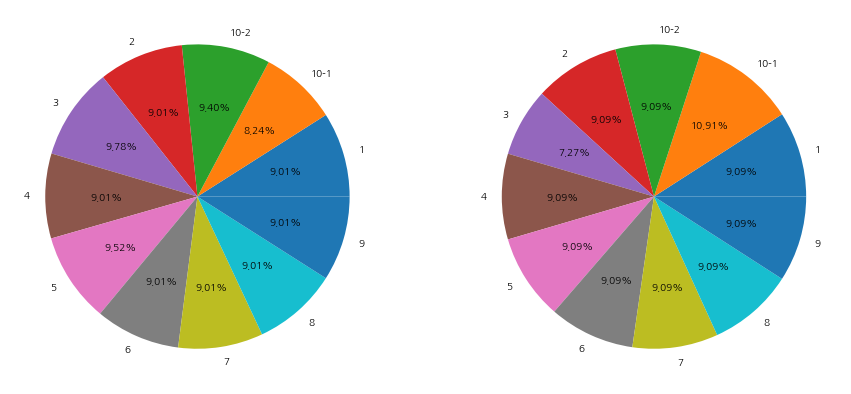

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].pie(train_df["ClassId"].value_counts().sort_index().values, labels=train_df["ClassId"].value_counts().sort_index().index, autopct="%.2f%%")
ax[1].pie(test_df["ClassId"].value_counts().sort_index().values, labels=test_df["ClassId"].value_counts().sort_index().index, autopct="%.2f%%")
plt.show()

`train`과 `test` 모두 데이터가 고르게 잘 들어있음  
다만, 10을 나타내는 수어가 2 종류인 점을 감안하면, 10은 다른 숫자보다 약 2배 더 많음

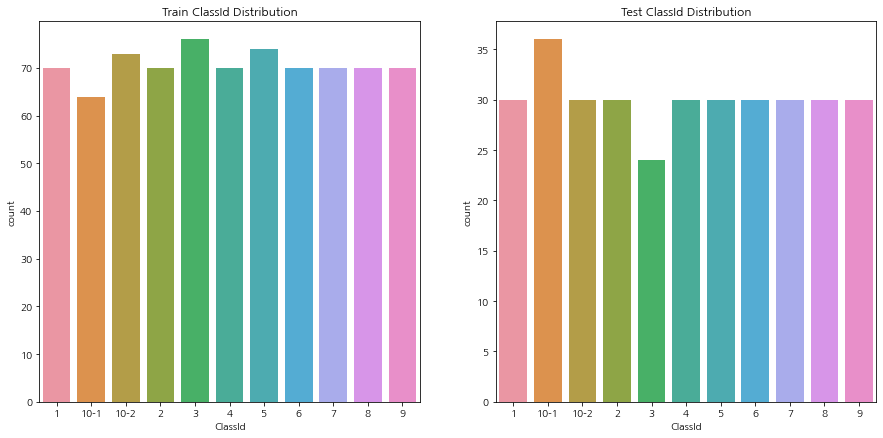

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sns.countplot(x=train_df["ClassId"], ax=ax[0]).set_title("Train ClassId Distribution")
sns.countplot(x=test_df["ClassId"], ax=ax[1]).set_title("Test ClassId Distribution")
plt.show()

데이터의 절대량은, `train`은 70개 전후, `test`는 30개 전후여서 데이터 증강이 필요할꺼라 생각됨

### 예시 이미지 출력

In [10]:
def img_resize_to_gray(fpath):
    """파일 경로를 입력 받아 사이즈 조정과 그레이로 변환하는 함수

    Args:
        fpath (str): 파일 경로
    Returns:
        arr (np.array)
    """
    img = cv2.imread(fpath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (300, 300))
    return img

In [11]:
plot_df = train_df.sample(25)

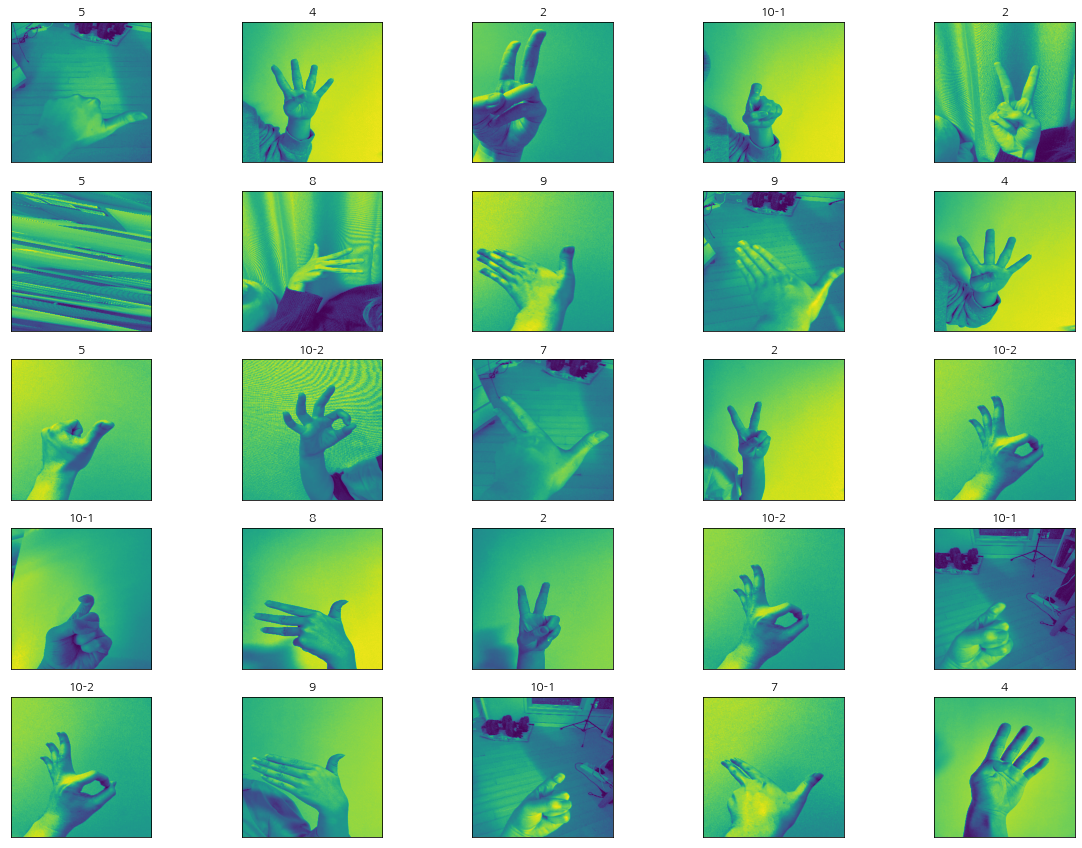

In [12]:
fig, ax = plt.subplots(5, 5, figsize=(20, 15))
for idx, fpath in enumerate(plot_df["path"]):
    classid = fpath.split("\\")[1]
    plt.subplot(5, 5, idx+1)
    plt.imshow(img_resize_to_gray(fpath))
    plt.title(classid)
    plt.xticks([])
    plt.yticks([])

### Image Data Generator

In [13]:
splitfolders.ratio(input="./archive/train/", output="./archive/kor_number", ratio=(0.9, 0.05, 0.05))

Copying files: 824 files [00:04, 196.93 files/s]


In [14]:
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory("./archive/kor_number/train/", target_size=(300, 300), batch_size=32, shuffle=True, class_mode='sparse')
test_generator = test_datagen.flow_from_directory("./archive/kor_number/test/", target_size=(300,300), batch_size=32, shuffle=False, class_mode='sparse')
val_generator = val_datagen.flow_from_directory("./archive/kor_number/val/", target_size=(300,300), batch_size=32, shuffle=False, class_mode='sparse')

Found 689 images belonging to 11 classes.
Found 54 images belonging to 11 classes.
Found 34 images belonging to 11 classes.


### Model: Efficient Net

In [15]:
from tensorflow.keras.applications import EfficientNetB0

model = EfficientNetB0(
    input_shape=(300, 300, 3),
    include_top=False,
    weights="imagenet"
)

### Fine Tuning

In [16]:
model.trainable = True

for layer in model.layers[:-15]:
    layer.trainable = False
    
x = tf.keras.layers.Flatten()(model.output)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(11, activation="softmax")(x)

model = tf.keras.Model(model.input, x)

model.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ["accuracy"]
)

### Train

In [17]:
early_stopping = EarlyStopping(monitor="val_accuracy", mode="max", verbose=0, patience=10)
model_check = ModelCheckpoint("model_kor_num_no_augmentation.h5", monitor="val_accuracy", mode="max", save_best_only=True)

In [18]:
with tf.device("/device:GPU:0"):
    history = model.fit(train_generator, validation_data=val_generator, epochs=50, verbose=1, callbacks=[early_stopping, model_check])

Epoch 1/50
22/22 [==============================] - 76s 2s/step - loss: 4.1347 - accuracy: 0.4731 - val_loss: 1.7526 - val_accuracy: 0.7353
Epoch 2/50
22/22 [==============================] - 75s 3s/step - loss: 0.8099 - accuracy: 0.8462 - val_loss: 2.8852 - val_accuracy: 0.7647
Epoch 3/50
22/22 [==============================] - 63s 3s/step - loss: 0.4242 - accuracy: 0.9303 - val_loss: 3.3324 - val_accuracy: 0.7941
Epoch 4/50
22/22 [==============================] - 58s 3s/step - loss: 0.3403 - accuracy: 0.9332 - val_loss: 3.3216 - val_accuracy: 0.7647
Epoch 5/50
22/22 [==============================] - 45s 2s/step - loss: 0.3478 - accuracy: 0.9565 - val_loss: 4.5897 - val_accuracy: 0.7941
Epoch 6/50
22/22 [==============================] - 58s 3s/step - loss: 0.1667 - accuracy: 0.9695 - val_loss: 3.4514 - val_accuracy: 0.7353
Epoch 7/50
22/22 [==============================] - 75s 3s/step - loss: 0.2223 - accuracy: 0.9695 - val_loss: 2.9274 - val_accuracy: 0.7941
Epoch 8/50
22/22 [==

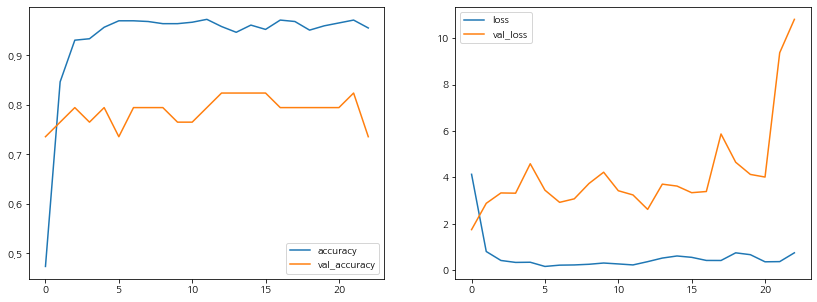

In [19]:
hist_df = pd.DataFrame(history.history)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
hist_df[["accuracy", "val_accuracy"]].plot(ax=ax[0])
hist_df[["loss", "val_loss"]].plot(ax=ax[1])
plt.show()

### Model Evaluation

In [20]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print('Loss: %.3f' % (test_loss * 100.0))
print('Accuracy: %.3f' % (test_acc * 100.0)) 

2/2 [==============================] - 6s 2s/step - loss: 8.0187 - accuracy: 0.8148
Loss: 801.866
Accuracy: 81.481


In [21]:
y_val = test_generator.classes
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred,axis=1)

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       1.00      0.75      0.86         4
           2       0.83      1.00      0.91         5
           3       0.50      1.00      0.67         5
           4       0.50      0.20      0.29         5
           5       0.80      0.80      0.80         5
           6       1.00      0.60      0.75         5
           7       0.71      1.00      0.83         5
           8       1.00      0.80      0.89         5
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         5

    accuracy                           0.81        54
   macro avg       0.85      0.81      0.81        54
weighted avg       0.85      0.81      0.81        54



### To Do: Data Augmentation